# Homework 2.2: The Quest For A Better Network

In this assignment you will:

    1. Build a monster network to solve CIFAR10 image classification
    2. Apply your transfer learning skills to fine-tune your network to a restricted CIFAR100 dataset.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

We add a new task of fine-tuning a pretrained network for different classes of similar domain. After you obtain good results on CIFAR-10 dataset:

* choose any two classes from CIFAR-100
* change your trained network to be suitable for binary classification
* fine-tune it for reasonably good results on 2 classes from CIFAR-100
* repeat the same for random initialization of the same network
* compare the performance and training time in your report


 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +5% for beating each of these milestones on __TEST__ dataset:
    * 50% (45% points)
    * 60% (50% points)
    * 65% (55% points)
    * 70% (60% points)
    * 75% (65% points)
    * 80% (70% points)
* +30% for fine-tuning your best CIFAR-10 network for two classes from CIFAR-100, comparing the results with training the same network from scratch and reporting the results

    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))
   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.
 * __Network architecture__
   * Different ways to combine convolutional/pooling/activation layers
   * Regularization methods



### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Try different optimizers, especially Adam, RMSProp, Adagrad, SGD with momentum: ([torch.optim](http://pytorch.org/docs/0.3.1/optim.html))
   * Sometimes it makes sense to reduce LR during training: ([Dynamic learning rates](http://pytorch.org/docs/0.3.1/optim.html#how-to-adjust-learning-rate))
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recommend that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cifar import load_cifar10, load_cifar100
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


In [3]:
X_train100, y_train100, X_val100, y_val100, X_test100, y_test100 = load_cifar100('./cifar100/', 
                                                                                 target_classes=(17, 37))
print(X_train100.shape, y_train100.shape)
print(X_val100.shape, y_val100.shape)
print(X_test100.shape, y_test100.shape)

(800, 3, 32, 32) (800,)
(200, 3, 32, 32) (200,)
(200, 3, 32, 32) (200,)


In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
def set_increase_hflip(X_set, y_set):
    return np.concatenate((X_set,np.flip(X_set,axis=3))), np.concatenate((y_set,y_set));

In [4]:
def compute_loss_cuda(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

## CIFAR10

__ Training __

In [16]:
model = nn.Sequential();
model.add_module('conv1_1', nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3));
model.add_module('bn1_1', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_1', nn.ReLU(inplace=True));

model.add_module('conv1_2', nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3));
model.add_module('bn1_2', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_2', nn.ReLU(inplace=True));

model.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv2_1', nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3));
model.add_module('bn2_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_1', nn.ReLU(inplace=True));

model.add_module('conv2_2', nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3));
model.add_module('bn2_2', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_2', nn.ReLU(inplace=True));

model.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv3_1', nn.Conv2d(in_channels=192, out_channels=288, kernel_size=3));
model.add_module('bn3_1', nn.BatchNorm2d(num_features=288));
model.add_module('relu3_1', nn.ReLU(inplace=True));

model.add_module('conv4_1', nn.Conv2d(in_channels=288, out_channels=192, kernel_size=1));
model.add_module('bn4_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu4_1', nn.ReLU(inplace=True));

model.add_module('conv5_1', nn.Conv2d(in_channels=192, out_channels=10, kernel_size=1));
model.add_module('bn5_1', nn.BatchNorm2d(num_features=10));
model.add_module('relu5_1', nn.ReLU(inplace=True));

model.add_module('mp3', nn.MaxPool2d(kernel_size=2, stride=1));

model.add_module('flatten', Flatten())

In [17]:
#for cuda training
model.cuda()
import time
X_train_incr, y_train_incr = set_increase_hflip(X_train,y_train);
num_epochs = 30 # total amount of full passes over training data
batch_size = 500  # number of samples processed in one SGD iteration
train_loss = []
val_accuracy = []
opt = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9);
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train_incr, y_train_incr, batch_size):
        # train on batch
        loss = compute_loss_cuda(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 30 took 95.925s
  training loss (in-iteration): 	0.981748
  validation accuracy: 			61.93 %
Epoch 2 of 30 took 96.880s
  training loss (in-iteration): 	0.711793
  validation accuracy: 			69.22 %
Epoch 3 of 30 took 96.606s
  training loss (in-iteration): 	0.575374
  validation accuracy: 			73.76 %
Epoch 4 of 30 took 96.109s
  training loss (in-iteration): 	0.481148
  validation accuracy: 			76.71 %
Epoch 5 of 30 took 96.672s
  training loss (in-iteration): 	0.403497
  validation accuracy: 			75.16 %
Epoch 6 of 30 took 96.066s
  training loss (in-iteration): 	0.333914
  validation accuracy: 			76.64 %
Epoch 7 of 30 took 96.742s
  training loss (in-iteration): 	0.272198
  validation accuracy: 			78.72 %
Epoch 8 of 30 took 95.978s
  training loss (in-iteration): 	0.221579
  validation accuracy: 			76.48 %
Epoch 9 of 30 took 95.494s
  training loss (in-iteration): 	0.178425
  validation accuracy: 			78.61 %
Epoch 10 of 30 took 95.419s
  training loss (in-iteration): 	0.138481
  v

In [19]:
torch.save(model.state_dict(), './trained/model_large_final_dict')

In [18]:
#for cuda
model.train(False)
model.cuda() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 256):
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		84.85 %
Achievement unlocked: 110lvl Warlock!


## CIFAR100

In [12]:
#improving y
def improvetarget(y,class1,class2):
    for i in range(len(y)):
        if y[i] == class1:
            y[i] = 0;
        elif y[i] == class2:
            y[i] = 1;
    return y;
y_train100 = improvetarget(y_train100,17,37);
y_val100 = improvetarget(y_val100,17,37);
y_test100 = improvetarget(y_test100,17,37);

### Training from scratch

In [19]:
#COPYPASTE from CIFAR10
model = nn.Sequential();
model.add_module('conv1_1', nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3));
model.add_module('bn1_1', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_1', nn.ReLU(inplace=True));

model.add_module('conv1_2', nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3));
model.add_module('bn1_2', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_2', nn.ReLU(inplace=True));

model.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv2_1', nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3));
model.add_module('bn2_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_1', nn.ReLU(inplace=True));

model.add_module('conv2_2', nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3));
model.add_module('bn2_2', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_2', nn.ReLU(inplace=True));

model.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv3_1', nn.Conv2d(in_channels=192, out_channels=288, kernel_size=3));
model.add_module('bn3_1', nn.BatchNorm2d(num_features=288));
model.add_module('relu3_1', nn.ReLU(inplace=True));

model.add_module('conv4_1', nn.Conv2d(in_channels=288, out_channels=192, kernel_size=1));
model.add_module('bn4_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu4_1', nn.ReLU(inplace=True));

model.add_module('conv5_1', nn.Conv2d(in_channels=192, out_channels=10, kernel_size=1));
model.add_module('bn5_1', nn.BatchNorm2d(num_features=10));
model.add_module('relu5_1', nn.ReLU(inplace=True));

model.add_module('mp3', nn.MaxPool2d(kernel_size=2, stride=1));

model.add_module('flatten', Flatten())

#improving last layer for 2 class classification
model._modules['conv5_1'] = nn.Conv2d(in_channels=192, out_channels=2, kernel_size=1);
model._modules['bn5_1'] = nn.BatchNorm2d(num_features=2);

In [20]:
#for cuda training
model.cuda()
import time
X_train_incr, y_train_incr = set_increase_hflip(X_train100,y_train100);
num_epochs = 65 # total amount of full passes over training data
batch_size = 500  # number of samples processed in one SGD iteration
train_loss = []
val_accuracy = []
opt = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9);
#opt = torch.optim.Adam(model.parameters());
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train_incr, y_train_incr, batch_size):
        # train on batch
        loss = compute_loss_cuda(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val100, y_val100, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 65 took 0.677s
  training loss (in-iteration): 	0.667708
  validation accuracy: 			46.00 %
Epoch 2 of 65 took 0.662s
  training loss (in-iteration): 	0.600495
  validation accuracy: 			46.00 %
Epoch 3 of 65 took 0.697s
  training loss (in-iteration): 	0.561482
  validation accuracy: 			46.00 %
Epoch 4 of 65 took 0.697s
  training loss (in-iteration): 	0.527642
  validation accuracy: 			46.00 %
Epoch 5 of 65 took 0.667s
  training loss (in-iteration): 	0.497899
  validation accuracy: 			46.10 %
Epoch 6 of 65 took 0.665s
  training loss (in-iteration): 	0.466576
  validation accuracy: 			47.17 %
Epoch 7 of 65 took 0.665s
  training loss (in-iteration): 	0.443370
  validation accuracy: 			47.93 %
Epoch 8 of 65 took 0.668s
  training loss (in-iteration): 	0.420281
  validation accuracy: 			49.56 %
Epoch 9 of 65 took 0.664s
  training loss (in-iteration): 	0.400282
  validation accuracy: 			51.28 %
Epoch 10 of 65 took 0.665s
  training loss (in-iteration): 	0.382234
  validation 

In [21]:
#for cuda
model.train(False)
model.cuda() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test100, y_test100, 100):
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		81.50 %
Achievement unlocked: 110lvl Warlock!


### Using pre-trained CIFAR10 network

In [22]:
#COPYPASTE from CIFAR10
model = nn.Sequential();
model.add_module('conv1_1', nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3));
model.add_module('bn1_1', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_1', nn.ReLU(inplace=True));

model.add_module('conv1_2', nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3));
model.add_module('bn1_2', nn.BatchNorm2d(num_features=96));
model.add_module('relu1_2', nn.ReLU(inplace=True));

model.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv2_1', nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3));
model.add_module('bn2_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_1', nn.ReLU(inplace=True));

model.add_module('conv2_2', nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3));
model.add_module('bn2_2', nn.BatchNorm2d(num_features=192));
model.add_module('relu2_2', nn.ReLU(inplace=True));

model.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=2));

model.add_module('conv3_1', nn.Conv2d(in_channels=192, out_channels=288, kernel_size=3));
model.add_module('bn3_1', nn.BatchNorm2d(num_features=288));
model.add_module('relu3_1', nn.ReLU(inplace=True));

model.add_module('conv4_1', nn.Conv2d(in_channels=288, out_channels=192, kernel_size=1));
model.add_module('bn4_1', nn.BatchNorm2d(num_features=192));
model.add_module('relu4_1', nn.ReLU(inplace=True));

model.add_module('conv5_1', nn.Conv2d(in_channels=192, out_channels=10, kernel_size=1));
model.add_module('bn5_1', nn.BatchNorm2d(num_features=10));
model.add_module('relu5_1', nn.ReLU(inplace=True));

model.add_module('mp3', nn.MaxPool2d(kernel_size=2, stride=1));

model.add_module('flatten', Flatten())

#Loading pre-trained net for CIFAR10 classifiaction 
model.load_state_dict(torch.load('./trained/model_large_final_dict'))

#improving last layer for 2 class classification
model._modules['conv5_1'] = nn.Conv2d(in_channels=192, out_channels=2, kernel_size=1);
model._modules['bn5_1'] = nn.BatchNorm2d(num_features=2);

In [23]:
#for cuda training
model.cuda()
import time
X_train_incr, y_train_incr = set_increase_hflip(X_train100,y_train100);
num_epochs = 50 # total amount of full passes over training data
batch_size = 500  # number of samples processed in one SGD iteration
train_loss = []
val_accuracy = []
opt = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9);
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train_incr, y_train_incr, batch_size):
        # train on batch
        loss = compute_loss_cuda(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val100, y_val100, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 50 took 0.671s
  training loss (in-iteration): 	0.629397
  validation accuracy: 			74.00 %
Epoch 2 of 50 took 0.673s
  training loss (in-iteration): 	0.565995
  validation accuracy: 			78.75 %
Epoch 3 of 50 took 0.691s
  training loss (in-iteration): 	0.513273
  validation accuracy: 			81.00 %
Epoch 4 of 50 took 0.665s
  training loss (in-iteration): 	0.470221
  validation accuracy: 			81.00 %
Epoch 5 of 50 took 0.667s
  training loss (in-iteration): 	0.426547
  validation accuracy: 			79.30 %
Epoch 6 of 50 took 0.663s
  training loss (in-iteration): 	0.385388
  validation accuracy: 			79.17 %
Epoch 7 of 50 took 0.666s
  training loss (in-iteration): 	0.347273
  validation accuracy: 			79.64 %
Epoch 8 of 50 took 0.669s
  training loss (in-iteration): 	0.313738
  validation accuracy: 			79.38 %
Epoch 9 of 50 took 0.664s
  training loss (in-iteration): 	0.284717
  validation accuracy: 			79.11 %
Epoch 10 of 50 took 0.665s
  training loss (in-iteration): 	0.259977
  validation 

In [24]:
#for cuda
model.train(False)
model.cuda() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test100, y_test100, 100):
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		85.00 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the perfect one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Iaroslav Koshelev`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, I got an idea:

##### Brief explanation of the main idea behind the method
I am going to be honest, so I firstly started with pytorch CIFAR10 tutorial https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py simply to get used to notations and training scheme. Instead of writing the network as a class, as it is done in an example, I rewrote it using more familliar to me (after 1st homework) sequential container and added batch normalization after trying it in the 1st homework and reading an article about it: https://arxiv.org/pdf/1502.03167.pdf . With that I achieved  51% accuracy and also slightly improved that jupyter notebook for more convinient work. Then I started to experiment with that network. I removed all fully connected layers, increased channels number and added new convolution+bathcnorm+relu+maxpool layers. The main idea was to use only valid convolutional layers without any fully-connected ones and to achieve after the last layer batch with 10 channels and 1x1 spatial size. I tuned it at the following way: I commented last layers, tried the network on a small batch and looked at the shape of the output. After achieving the needed result I simply flatten it to receive an array size of number of classes (10). The goal of that was to get rid of all fully-connected layers for on one hand the "sport interest" and on another one for the decrease of traning time. Also I experimented with different optimizers (Adam and SGD), read this https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ and found for myself SGD faster and better, so do I changed optimizer to SGD with high learning rate (lr=0.01) for better convergence. With that I achieved 61% accuracy. I did not use softmax as the last layer, because it is already implemented in loss computing function - torch.nn.functional.cross_entropy() due to documentation: "This criterion combines log_softmax and nll_loss in a single function." 

In order to highly increase accuracy I decided to construct a massive network but with same ideas I tried before. So I read articles about CIFAR10 classification networks: 
https://arxiv.org/pdf/1409.6070.pdf
https://arxiv.org/pdf/1412.6071.pdf

As I wanted to use sequential network with only convolutional layers, I found a network familliar to this ideas here: https://arxiv.org/pdf/1412.6806.pdf at Table 1-C. I implemented it with batchnorm after all convolutional layers. As in the previous case I tested the output shape of the network commenting last layers. I tried then to train it and achieved around 80% accuracy, but that was unstable of getting above 80%. As in previous case, I tested Adam and SGD and found SGD to present better performance, so I used it. In order to get stable above 80% result I doubled the trainset by adding horizontally flipped images. Also I increased channels number from 192 to 288 on one convolutional layer in the middle of the net. Then I tried to train the net with extremely hith SGD learning rate (lr=0.1) and found the convergence really fast and good, so I used that type of optimizer. 

In result, the training method is pretty dull, but I experimented and found it the most effective: 30 epochs of SGD with extremely high constant learning rate (lr=0.1) and (momentum=0.9) on trainset consisting of initial images and their flipped copies. 

The only regularization used in the network is BatchNormalization, which gave a stable good results in all networks I ever wrote and tested. 


##### Results
Training of CIFAR10:

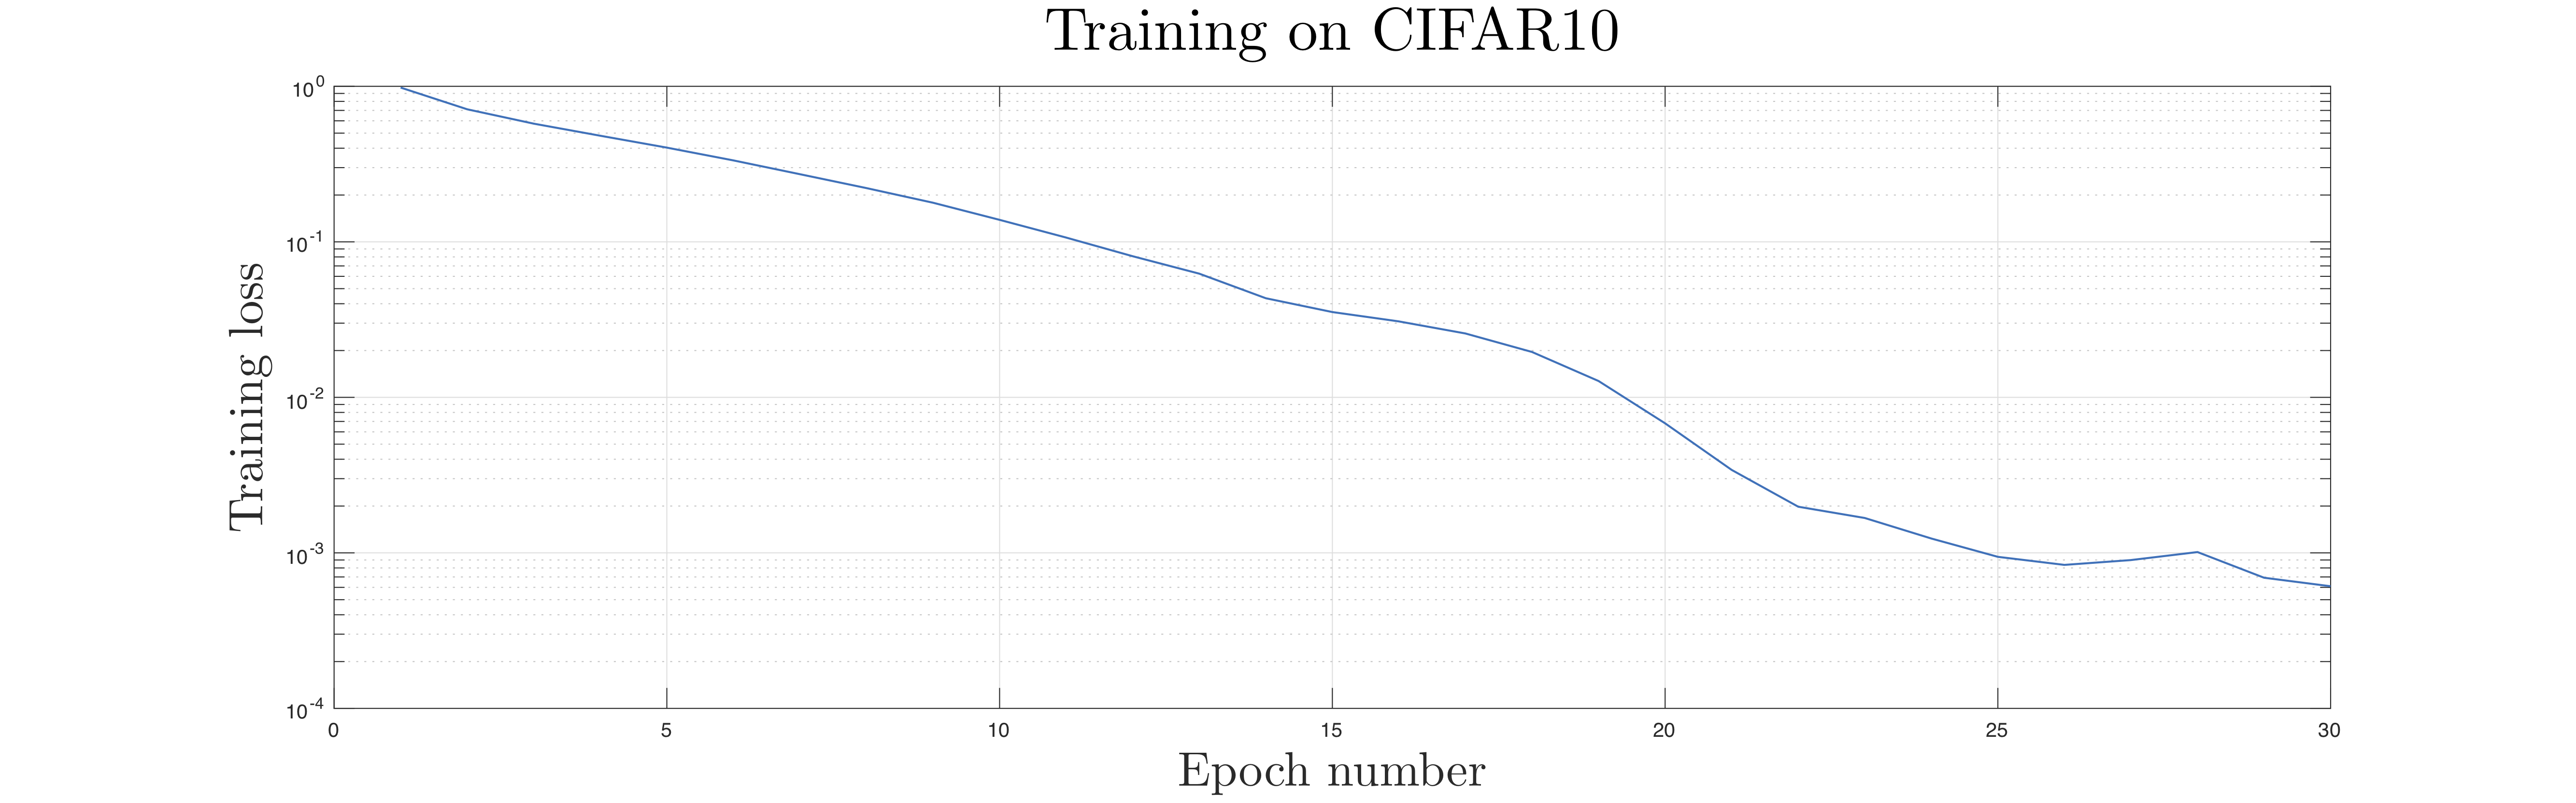

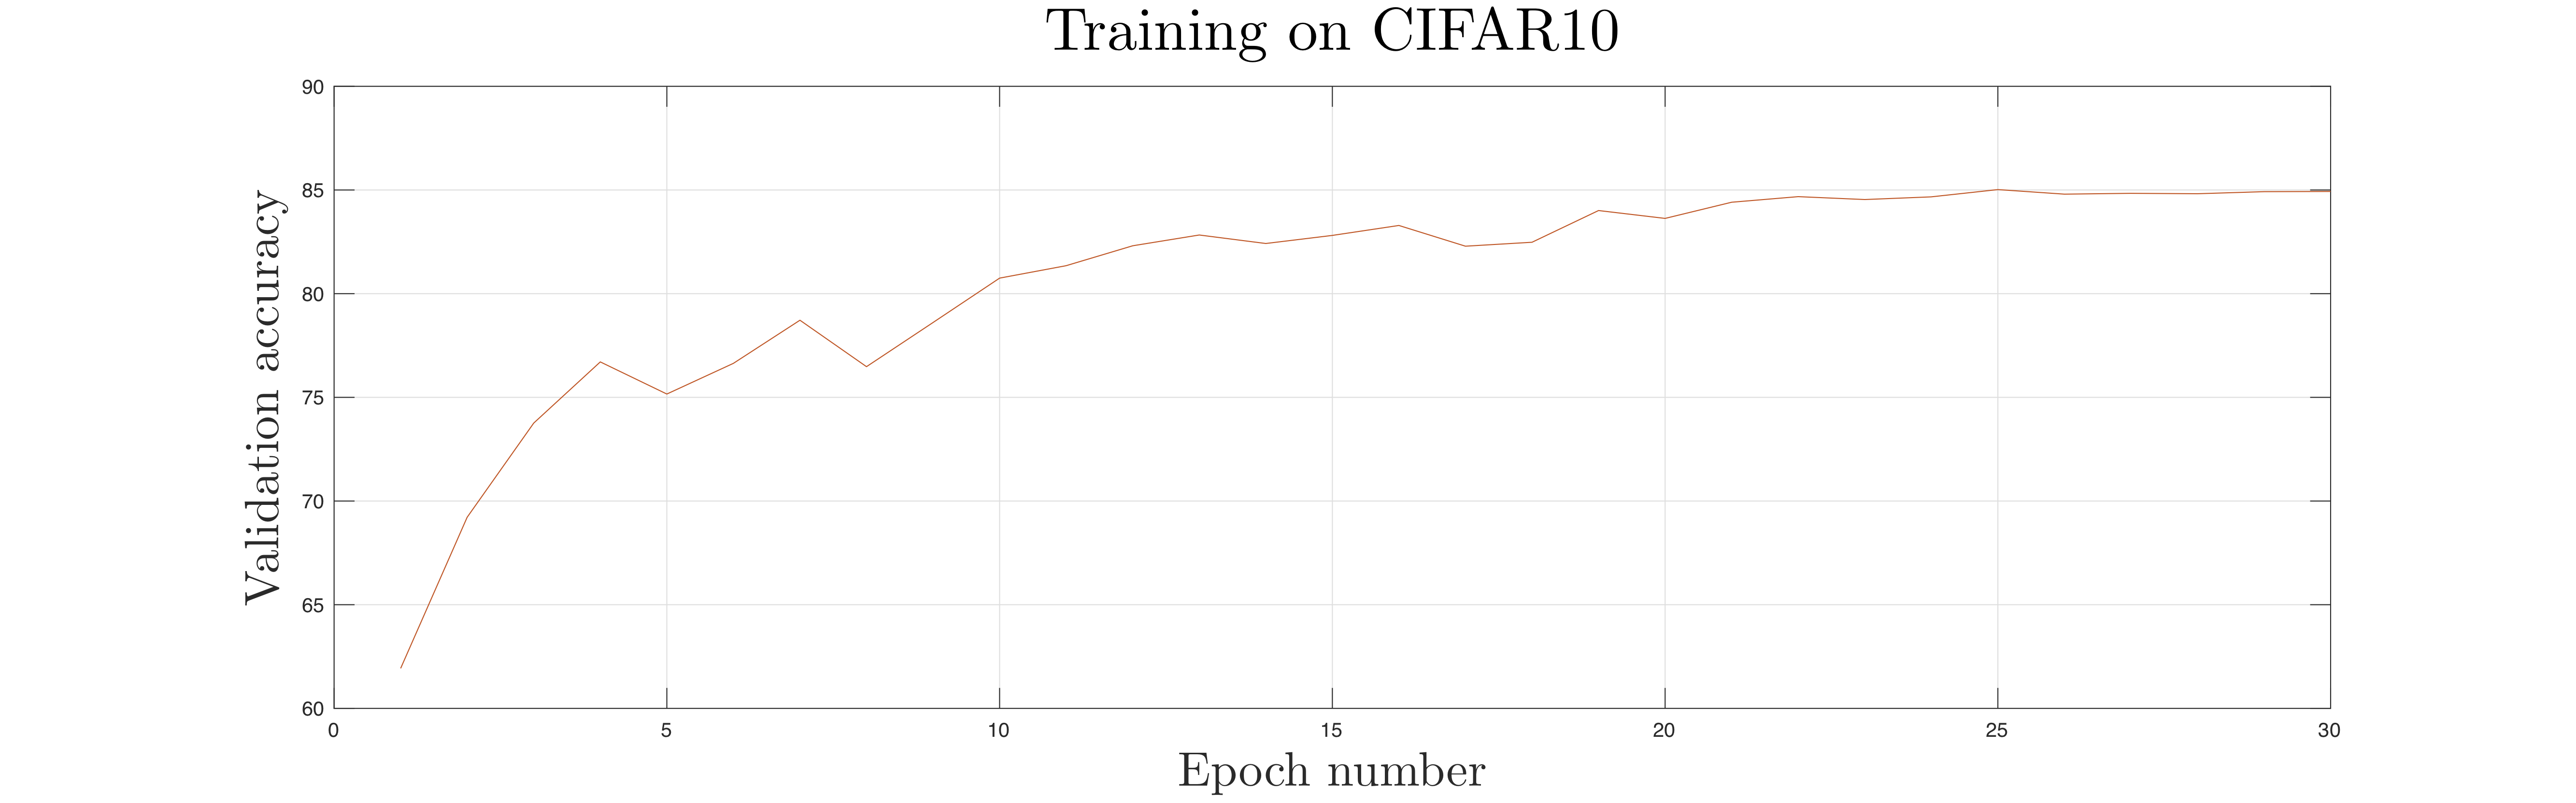

Training of CIFAR10:

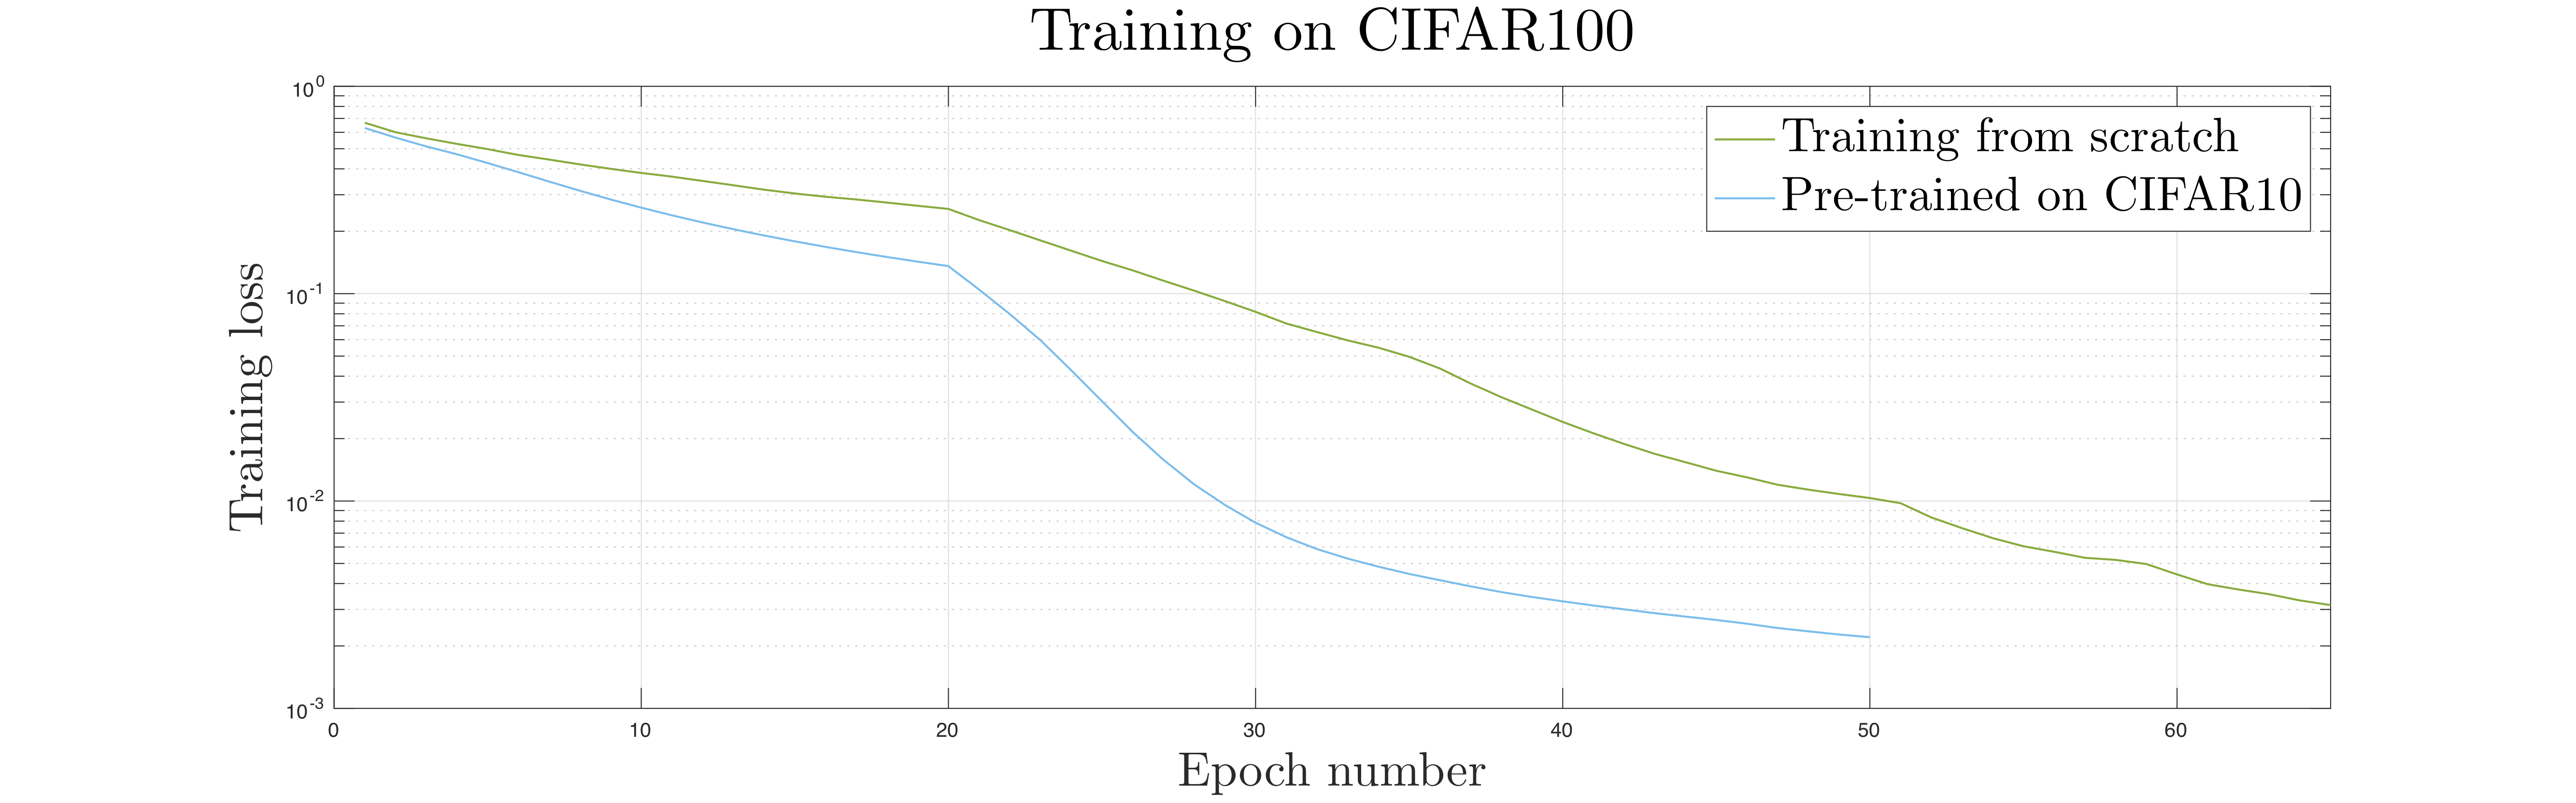

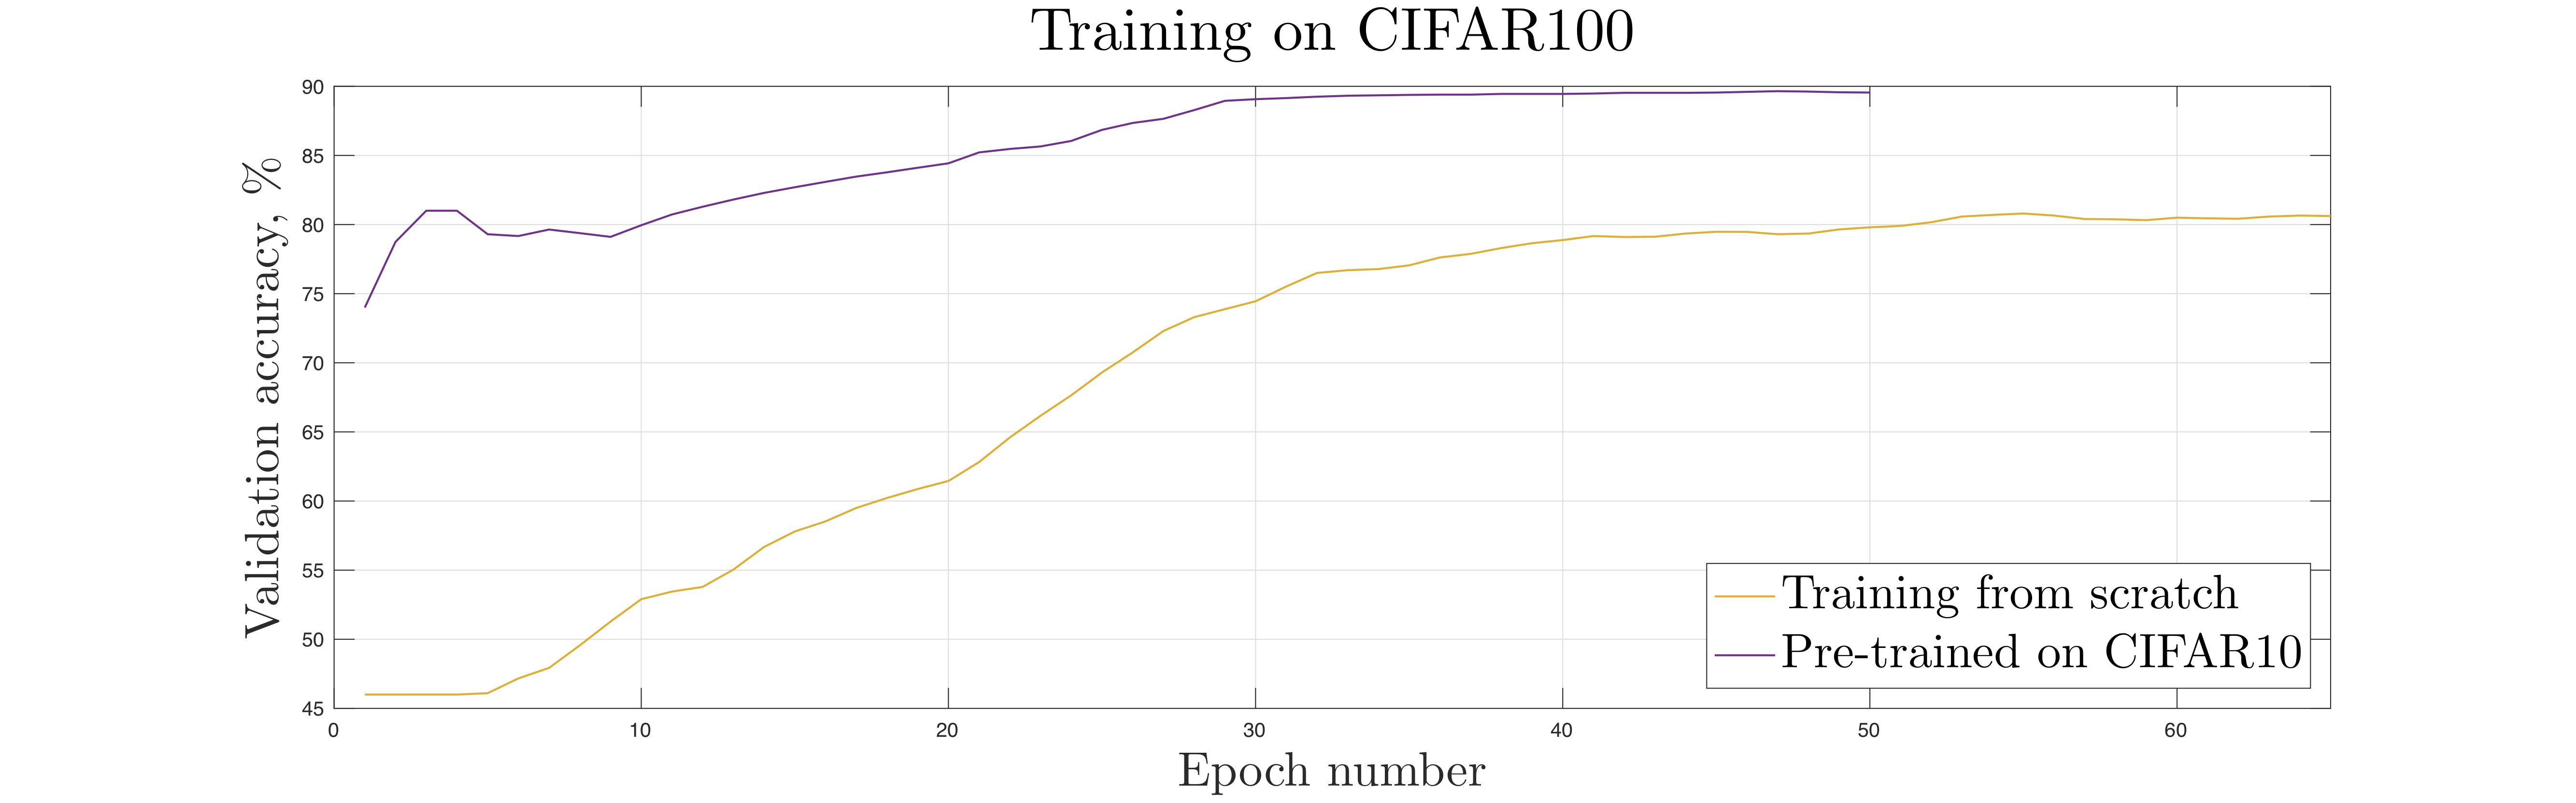


It is obvious from graphs that CIFAR100 based on pre-trained CIFAR10 trains much faster (50 vs 65 epoches) and with higher validation accuracy than training from scratch (89.55% vs 80.62%). The results on training set are also about 5% higher for pre-trained network than for trained from scratch.
##### The best solution for CIFAR10
* The final architecture is:

Sequential(

  (conv1_1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  
  (bn1_1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  
  (relu1_1): ReLU(inplace)
  
  (conv1_2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  
  (bn1_2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  
  (relu1_2): ReLU(inplace)
  
  (mp1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  
  (conv2_1): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  
  (bn2_1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu2_1): ReLU(inplace)
  
  (conv2_2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  
  (bn2_2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu2_2): ReLU(inplace)
  
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  
  (conv3_1): Conv2d(192, 288, kernel_size=(3, 3), stride=(1, 1))
  
  (bn3_1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True)
  
  (relu3_1): ReLU(inplace)
  
  (conv4_1): Conv2d(288, 192, kernel_size=(1, 1), stride=(1, 1))
  
  (bn4_1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu4_1): ReLU(inplace)
  
  (conv5_1): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1))
  
  (bn5_1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True)
  
  (relu5_1): ReLU(inplace)
  
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1), ceil_mode=False)
  
  (flatten): Flatten()
  
)
* Training method is simple: SGD with constant lr=0.1 and momentum=0.9 for 30 epochs on training set consisting of original images and their flipped copies. Average time for 1 epoch with CUDA: 95 seconds

Results:
* trainin loss: 0.000610
* accuracy on validation: 84.93%
* accuracy on test: 84.85%

##### The best solution for CIFAR100
* The final architecture is:

Sequential(

  (conv1_1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  
  (bn1_1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  
  (relu1_1): ReLU(inplace)
  
  (conv1_2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  
  (bn1_2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  
  (relu1_2): ReLU(inplace)
  
  (mp1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  
  (conv2_1): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  
  (bn2_1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu2_1): ReLU(inplace)
  
  (conv2_2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  
  (bn2_2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu2_2): ReLU(inplace)
  
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  
  (conv3_1): Conv2d(192, 288, kernel_size=(3, 3), stride=(1, 1))
  
  (bn3_1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True)
  
  (relu3_1): ReLU(inplace)
  
  (conv4_1): Conv2d(288, 192, kernel_size=(1, 1), stride=(1, 1))
  
  (bn4_1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  
  (relu4_1): ReLU(inplace)
  
  Loaded pre-trained CIFAR10 network dictionary
  
  (conv5_1): Conv2d(192, 2, kernel_size=(1, 1), stride=(1, 1))
  
  (bn5_1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  
  (relu5_1): ReLU(inplace)
  
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1), ceil_mode=False)
  
  (flatten): Flatten()
  
)
* Training method is simple: SGD with constant lr=0.1 and momentum=0.9 for 50 epochs on training set consisting of original images and their flipped copies.

Results for CIFAR100 with pre-trained on CIFAR10:
* trainin loss: 0.002204
* accuracy on validation: 89.55% 
* accuracy on test: 85.00%